#### pyWaPOR vs. WaPOR

In this notebook we'll make an comparison between dekadal Evapotranspiration data from WaPOR and from pyWaPOR.

First we install pywapor, in case it's not installed yet.

In [ ]:
!pip install pywapor==2.6.0 --quiet

Next we'll define a couple of basic variables, which were explained in the introduction notebook.

In [1]:
import pywapor

project_folder = r"/Users/hmcoerver/pywapor_notebooks_6"
timelim = ["2021-07-01", "2021-07-11"]
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]

Then we run `pre_et_look`, to generate an ET map for the first dekad of July 2021.

In [ ]:
ds_in = pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim)

Then we run `et_look`.

In [ ]:
ds = pywapor.et_look.main(ds_in, export_vars = ["et_24_mm"])

Now that we have the pyWaPOR ET map, we still need the WaPOR map in order to make a comparison. We can download this particular map like this.

In [2]:
import os
url = r"https://storage.googleapis.com/fao-cog-data/L1_AETI_D_WAPOR_DEKAD_2021.07.01.tif"
fp = os.path.join(project_folder, "wapor_eta.tif")

wapor_file = pywapor.collect.protocol.requests.download_url(url, fp)

Next, lets have a look at the two datasets side by side.

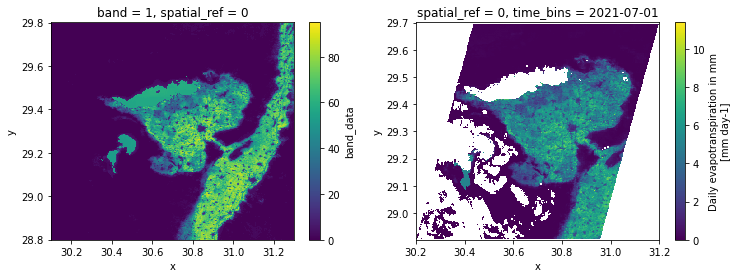

In [15]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset(r"/Users/hmcoerver/pywapor_notebooks_6/et_look_out.nc", decode_coords="all")

wapor_da = xr.open_dataset(wapor_file).isel(band = 0)["band_data"]
pywapor_da = ds.et_24_mm.isel(time_bins=0)

fig, axes = plt.subplots(ncols=2, figsize=(12,4))
wapor_da.plot(ax=axes[0])
pywapor_da.plot(ax=axes[1])

As you can see, the area covered by WaPOR is a bit larger, there are also some missing areas in pyWaPOR. Furthermore, the values in WaPOR seems to be about 10 times larger than pyWaPOR. We need to apply a scale factor to WaPOR.

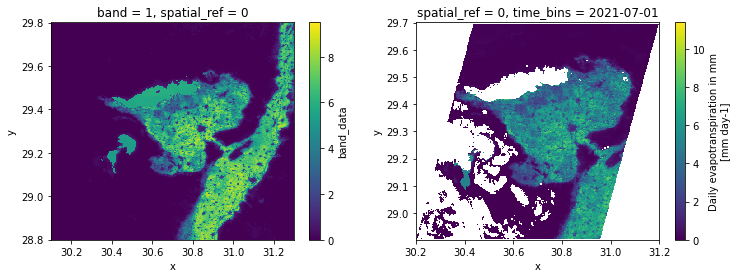

In [16]:
wapor_da= wapor_da * 0.1

fig, axes = plt.subplots(ncols=2, figsize=(12,4))
wapor_da.plot(ax=axes[0])
pywapor_da.plot(ax=axes[1])

We can also have a look at some other metadata.

In [17]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"count: {raster.count().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

print("WaPOR Raster:\n-------------")
print_raster(wapor_da)
print("pyWaPOR Raster:\n---------------")
print_raster(pywapor_da)

WaPOR Raster:
-------------
shape: (449, 539)
resolution: (0.0022321428599999973, -0.0022321428599999973)
bounds: (30.09821434836, 28.7991071428, 31.3013393499, 29.801339286940003)
count: 240576
CRS: EPSG:4326

pyWaPOR Raster:
---------------
shape: (418, 523)
resolution: (0.0019128390588680371, -0.0019128390588680371)
bounds: (30.199746759913452, 28.90147493739254, 31.200161587701434, 29.70104166399938)
count: 132170
CRS: EPSG:4326



Projections are the same, but shape and pixel sizes are slighly different. Let make them match with eachother, so that we can make a comparison between the two arrays.

In [18]:
wapor_da = wapor_da.rio.reproject_match(pywapor_da)

pywapor_da = pywapor_da.where(wapor_da.notnull())
wapor_da = wapor_da.where(pywapor_da.notnull())

WaPOR Raster:
-------------
shape: (418, 523)
resolution: (0.001912839058868034, -0.0019128390588680415)
bounds: (30.199746759913452, 28.90147493739254, 31.200161587701434, 29.70104166399938)
count: 132170
CRS: EPSG:4326

pyWaPOR Raster:
---------------
shape: (418, 523)
resolution: (0.0019128390588680371, -0.0019128390588680371)
bounds: (30.199746759913452, 28.90147493739254, 31.200161587701434, 29.70104166399938)
count: 132170
CRS: EPSG:4326



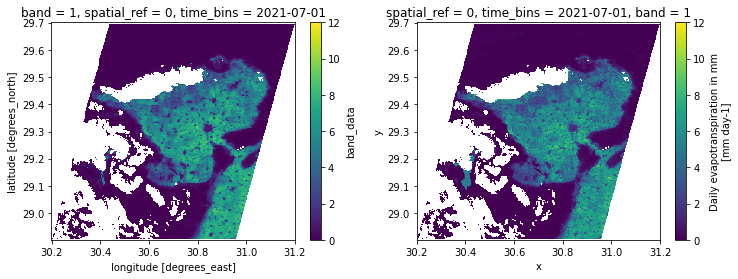

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
wapor_da.plot(ax=axes[0], vmin = 0, vmax = 12)
pywapor_da.plot(ax=axes[1], vmin = 0, vmax = 12)

print("WaPOR Raster:\n-------------")
print_raster(wapor_da)
print("pyWaPOR Raster:\n---------------")
print_raster(pywapor_da)

In [20]:
import numpy as np
import pywapor as pywapor_mod

def plot_hexbin(ax, arrays, xlabel = "", ylabel = ""):
    minmax = [np.min(arrays), np.max(arrays)]
    ax.plot(minmax, minmax, ":k", label = "1:1")
    ax.legend()
    hb = ax.hexbin(*arrays, bins = "log")
    ax.set_facecolor(plt.cm.get_cmap('viridis')(0.0))
    ax.get_figure().colorbar(hb, label = "Number of pixels [-]")
    ax.set_xlim(minmax)
    ax.set_ylim(minmax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    nse = pywapor_mod.post_et_look.calc_nash_sutcliffe(arrays)[0]
    rmse = pywapor_mod.post_et_look.calc_rmse(arrays)[0]
    r = pywapor_mod.post_et_look.calc_pearson_correlation(arrays)[0]
    ax.set_title(f"r: {r:.3f}, nse: {nse:.3f}, rmse: {rmse:.3f}")

Finally, lets make a scatter plot to see the differences a bit better.

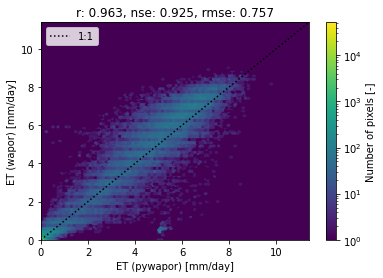

In [21]:
arrays = np.array([
    pywapor_da.stack({"pixel": ("y", "x")}).dropna("pixel"),
    wapor_da.stack({"pixel": ("y", "x")}).dropna("pixel")
])

fig = plt.figure()
ax = fig.gca()
plot_hexbin(ax, arrays,
            "ET (pywapor) [mm/day]", 
            "ET (wapor) [mm/day]")

Although there is some variance, the two maps are very similar. `et_look` is identical to the model used to create the WaPOR data, but `pre_et_look` is not. The solar-radiation (ra_24) product used in pyWaPOR is differnt from WaPOR as well. This variance can thus mainly be explained by differences in the preprocessing of the `et_look` input data.